# Data Visualization Using SQL (Extended)
This notebook demonstrates various ways to query and visualize the original dataset using SQL.

**Table of Contents**
- [1. Load Data and Create an In-Memory Database](#load_data)
- [2. Basic Query: Average Delivery Times](#basic_query)
- [3. More Complex Queries](#complex_queries)
    - [3.1 Aggregate by Day-of-Week and Hour-of-Day](#query_day_hour)
    - [3.2 Explore Weather Effects](#query_weather)
    - [3.3 Check Correlations Between Numeric Features](#query_corr)


## 1. Load Data and Create an In-Memory Database
<a id="load_data"></a>

In [1]:
import os
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.data_preprocessing import clean_data
from utils.feature_engineering import add_features

# 1. Load the CSV file
script_dir = os.path.dirname(os.path.abspath("."))
csv_path = os.path.join(script_dir, "data", "orders_autumn_2020.csv")
df = pd.read_csv(csv_path)
df = clean_data(df)
df = add_features(df)
# 2. Convert TIMESTAMP to datetime
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], errors='coerce')
df["DAY_OF_WEEK"] = df["TIMESTAMP"].dt.dayofweek
df["HOUR_OF_DAY"] = df["TIMESTAMP"].dt.hour

# 3. Create an in-memory SQLite database and import the DataFrame
output_plot_dir = os.path.join(script_dir, "figures")
conn = sqlite3.connect(":memory:")
df.to_sql("deliveries", conn, if_exists="replace", index=False)
df.head()

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION,DAY_OF_WEEK,HOUR_OF_DAY
0,2020-08-01 06:07:00,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0,5,6
1,2020-08-01 06:17:00,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0,5,6
2,2020-08-01 06:54:00,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0,5,6
3,2020-08-01 07:09:00,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0,5,7
4,2020-08-01 07:10:00,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0,5,7


## 2. Basic Query: Average Delivery Times
<a id="basic_query"></a>

In [2]:
# Compare average actual vs. estimated delivery times by day of week
sql_query = """
SELECT 
    DAY_OF_WEEK,
    AVG(ACTUAL_DELIVERY_MINUTES) AS avg_actual,
    AVG(ESTIMATED_DELIVERY_MINUTES) AS avg_estimated
FROM deliveries
GROUP BY DAY_OF_WEEK;
"""

result_df = pd.read_sql(sql_query, conn)
result_df

,DAY_OF_WEEK,avg_actual,avg_estimated
0,0,33.265424,34.764758
1,1,32.335076,33.836601
2,2,31.955241,33.518649
3,3,31.901952,33.241349
4,4,33.264117,34.479781
5,5,31.659529,32.792597
6,6,33.715824,34.194735


From this basic check, we can see the average actual and average estimated delivery times.

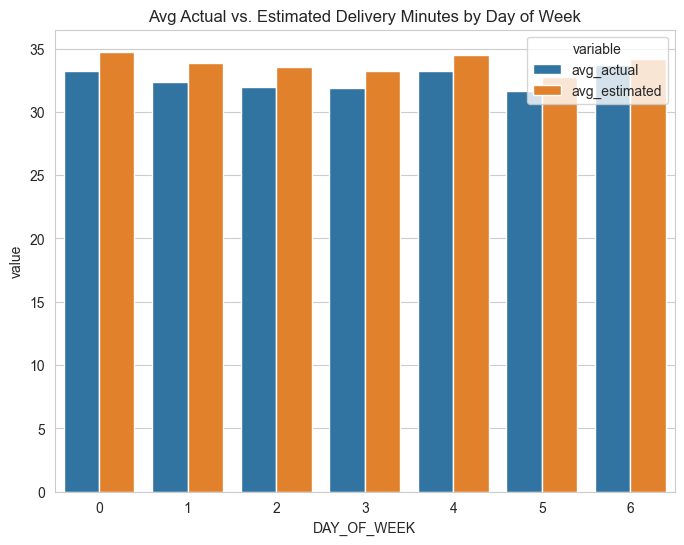

In [3]:
plt.figure(figsize=(8,6))
sns.barplot(x="DAY_OF_WEEK", y="value", hue="variable",
            data=pd.melt(result_df, ["DAY_OF_WEEK"]))
plt.title("Avg Actual vs. Estimated Delivery Minutes by Day of Week")
plt.savefig(os.path.join(output_plot_dir, "avg_delivery_times.png"))
plt.show()

## 3. More Complex Queries
<a id="complex_queries"></a>
Now let's explore how different factors (time of week, hour of day, weather conditions) relate to delivery times.

### 3.1. Aggregate by Day-of-Week and Hour-of-Day
<a id="query_day_hour"></a>

In [4]:
# Group by day-of-week and hour-of-day
sql_query = """
SELECT 
    DAY_OF_WEEK,
    HOUR_OF_DAY,
    COUNT(*) as order_count,
    AVG(ACTUAL_DELIVERY_MINUTES) as avg_actual,
    AVG(ESTIMATED_DELIVERY_MINUTES) as avg_estimated
FROM deliveries
GROUP BY DAY_OF_WEEK, HOUR_OF_DAY
ORDER BY DAY_OF_WEEK, HOUR_OF_DAY;
"""
day_hour_df = pd.read_sql(sql_query, conn)
day_hour_df.head(10)

,DAY_OF_WEEK,HOUR_OF_DAY,order_count,avg_actual,avg_estimated
0,0,4,1,17.000000,26.000000
1,0,5,9,28.111111,30.888889
2,0,6,27,30.037037,30.851852
3,0,7,82,28.524390,30.975610
4,0,8,203,34.615764,37.591133
5,0,9,194,37.350515,36.922680
6,0,10,185,35.216216,35.821622
7,0,11,138,30.181159,32.101449
8,0,12,146,28.972603,30.684932
9,0,13,209,32.717703,33.105263


**Visualize** how `avg_actual` changes by `DAY_OF_WEEK` and `HOUR_OF_DAY`.

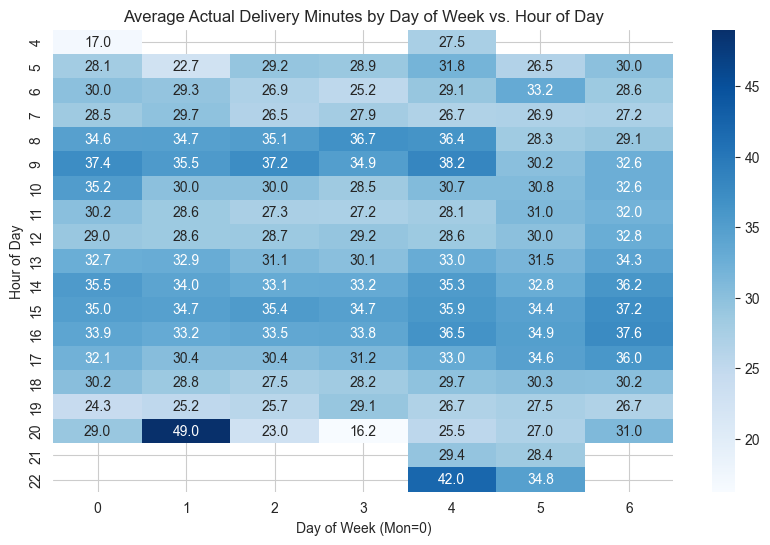

In [5]:
plt.figure(figsize=(10, 6))
pivoted = day_hour_df.pivot(index="HOUR_OF_DAY", columns="DAY_OF_WEEK", values="avg_actual")
sns.heatmap(pivoted, cmap="Blues", annot=True, fmt=".1f")
plt.title("Average Actual Delivery Minutes by Day of Week vs. Hour of Day")
plt.ylabel("Hour of Day")
plt.xlabel("Day of Week (Mon=0)")
plt.savefig(os.path.join(output_plot_dir, "heatmap_day_hour.png"))
plt.show()

### 3.2. Explore Weather Effects
<a id="query_weather"></a>
We'll see if there's a relationship between precipitation, temperature, and actual delivery times.

In [6]:
sql_query = """
SELECT
    ROUND(PRECIPITATION, 1) AS PRECIPITATION,
    ROUND(AVG(ACTUAL_DELIVERY_MINUTES), 2) AS avg_actual,
    ROUND(AVG(ESTIMATED_DELIVERY_MINUTES), 2) AS avg_estimated,
    COUNT(*) as order_count
FROM deliveries
GROUP BY ROUND(PRECIPITATION, 1)
ORDER BY PRECIPITATION;
"""
precip_df = pd.read_sql(sql_query, conn)
precip_df.head(15)

,PRECIPITATION,avg_actual,avg_estimated,order_count
0,0.0,32.41,33.72,17068
1,2.2,35.70,35.27,182
2,2.4,35.60,34.86,112
3,2.5,33.90,33.51,158
4,2.7,34.61,36.42,66
5,3.0,33.27,34.03,155
6,3.2,31.70,32.25,20
7,3.5,26.80,27.80,5
8,3.6,42.39,47.78,18
9,3.8,40.50,36.40,20


Visualize how average actual delivery time changes with precipitation amounts.

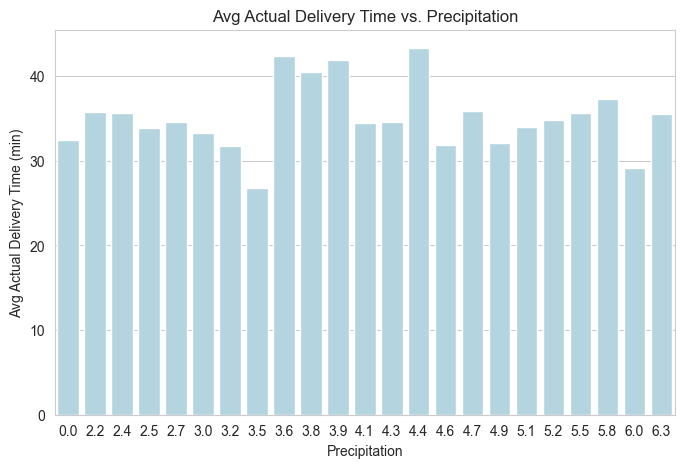

In [7]:
plt.figure(figsize=(8, 5))
sns.barplot(x="PRECIPITATION", y="avg_actual", data=precip_df, color="lightblue")
plt.title("Avg Actual Delivery Time vs. Precipitation")
plt.xlabel("Precipitation")
plt.ylabel("Avg Actual Delivery Time (min)")
plt.savefig(os.path.join(output_plot_dir, "avg_delivery_precip.png"))
plt.show()

Similarly, we can do a quick check on temperature influence.

In [8]:
sql_query = """
SELECT
    ROUND(TEMPERATURE, 1) AS TEMPERATURE,
    ROUND(AVG(ACTUAL_DELIVERY_MINUTES), 2) AS avg_actual,
    ROUND(AVG(ESTIMATED_DELIVERY_MINUTES), 2) AS avg_estimated,
    COUNT(*) as order_count
FROM deliveries
GROUP BY ROUND(TEMPERATURE, 1)
ORDER BY TEMPERATURE;
"""
temp_df = pd.read_sql(sql_query, conn)
temp_df.head(10)

,TEMPERATURE,avg_actual,avg_estimated,order_count
0,NaN,31.38,32.22,277
1,6.1,23.00,32.75,4
2,6.7,25.38,31.13,8
3,7.2,28.50,28.20,10
4,7.8,23.50,28.00,2
5,8.3,36.04,37.85,48
6,8.9,31.78,33.70,88
7,9.4,32.09,35.61,223
8,10.0,33.47,38.07,15
9,10.6,30.59,34.28,39


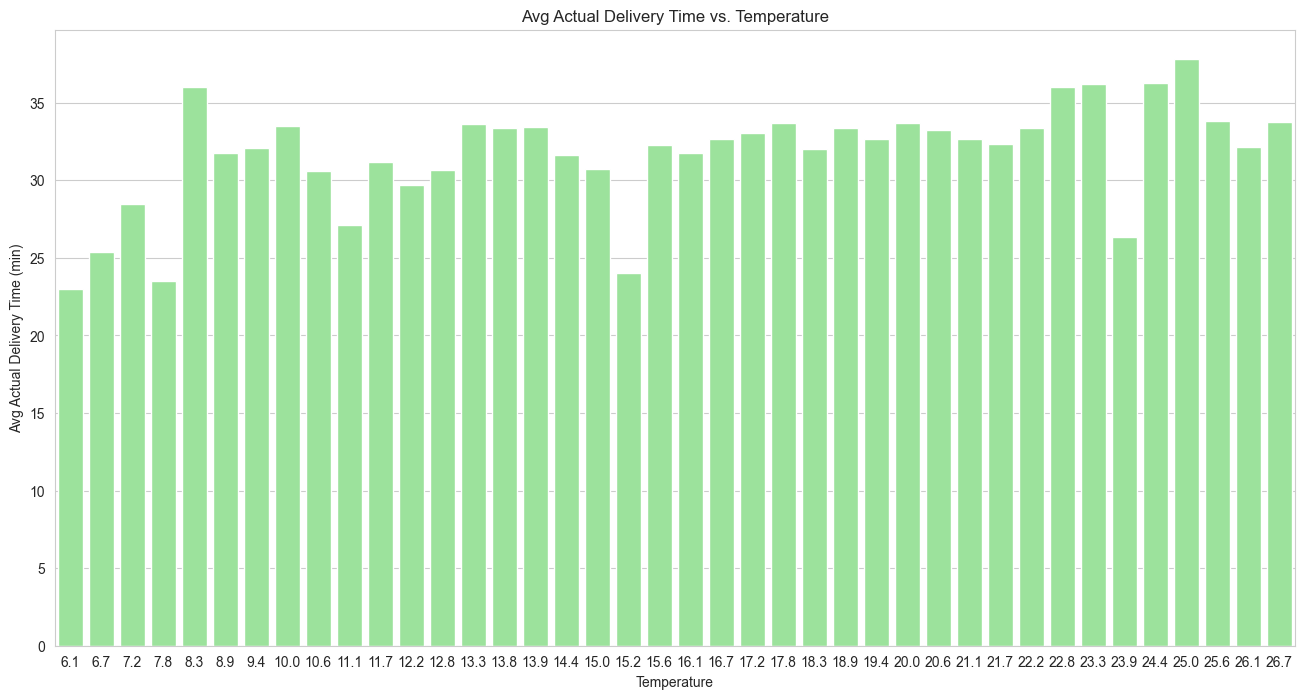

In [9]:
plt.figure(figsize=(16, 8))
sns.barplot(x="TEMPERATURE", y="avg_actual", data=temp_df, color="lightgreen")
plt.title("Avg Actual Delivery Time vs. Temperature")
plt.xlabel("Temperature")
plt.ylabel("Avg Actual Delivery Time (min)")
plt.savefig(os.path.join(output_plot_dir, "avg_delivery_temp.png"))
plt.show()

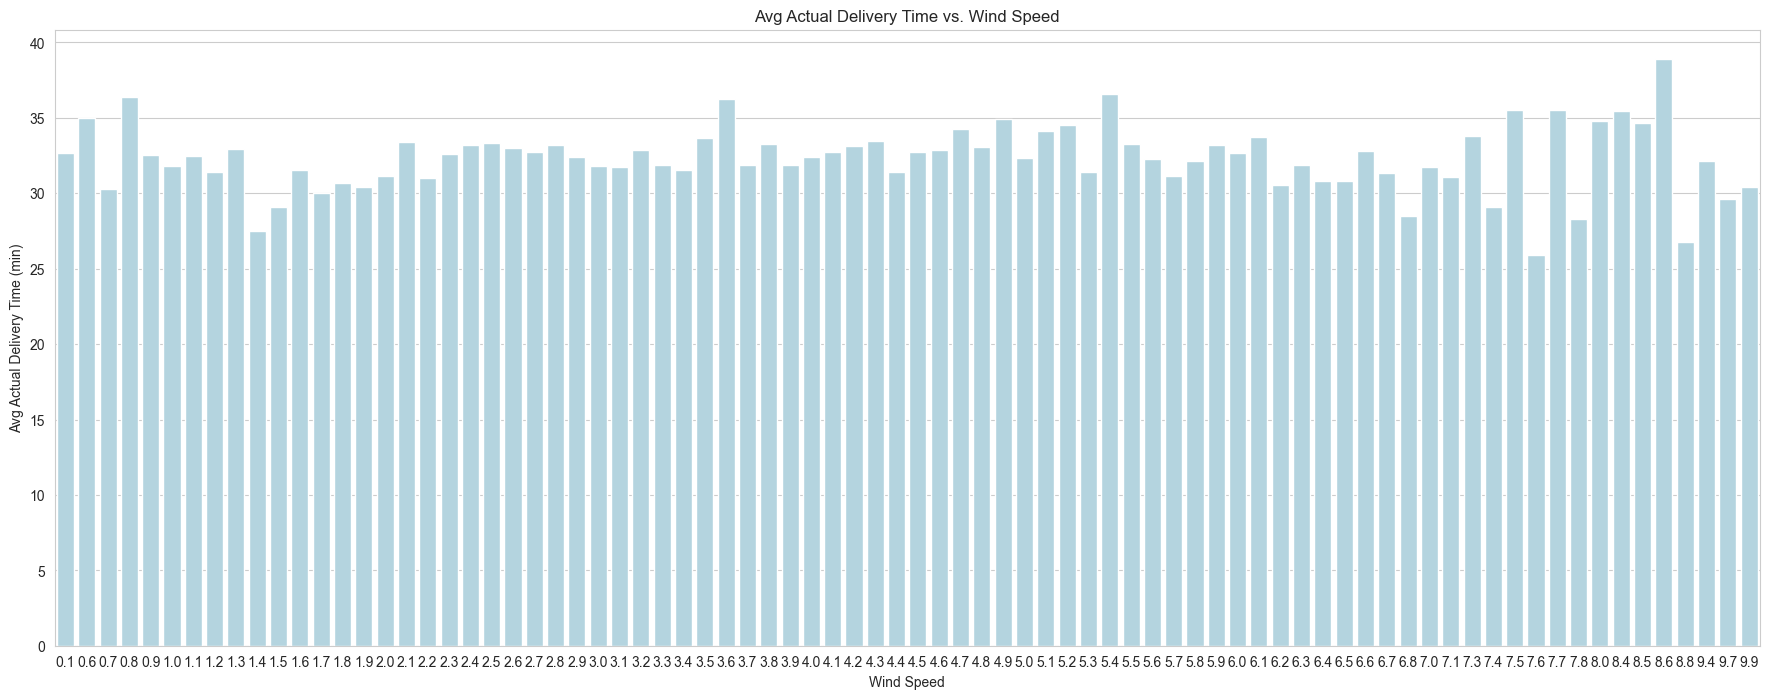

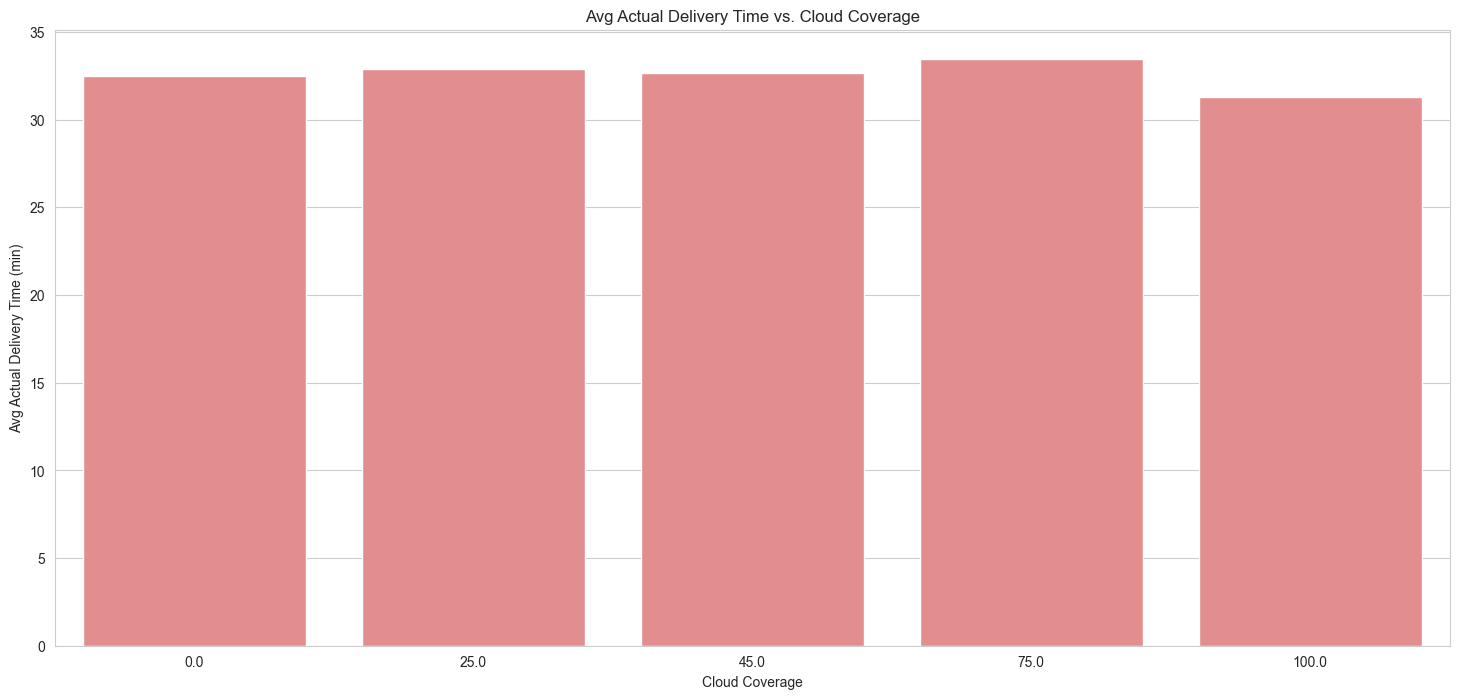

In [10]:
# Wind Speed
sql_query = """
SELECT
    ROUND(WIND_SPEED, 1) AS WIND_SPEED,
    ROUND(AVG(ACTUAL_DELIVERY_MINUTES), 2) AS avg_actual,
    ROUND(AVG(ESTIMATED_DELIVERY_MINUTES), 2) AS avg_estimated,
    COUNT(*) as order_count
FROM deliveries
GROUP BY ROUND(WIND_SPEED, 1)
ORDER BY WIND_SPEED;
"""
wind_df = pd.read_sql(sql_query, conn)
wind_df.head(10)
plt.figure(figsize=(22, 8))
sns.barplot(x="WIND_SPEED", y="avg_actual", data=wind_df, color="lightblue")
plt.title("Avg Actual Delivery Time vs. Wind Speed")
plt.xlabel("Wind Speed")
plt.ylabel("Avg Actual Delivery Time (min)")
plt.savefig(os.path.join(output_plot_dir, "avg_delivery_wind.png"))
plt.show()

# Cloud Coverage
sql_query = """
SELECT
    ROUND(CLOUD_COVERAGE, 1) AS CLOUD_COVERAGE,
    ROUND(AVG(ACTUAL_DELIVERY_MINUTES), 2) AS avg_actual,
    ROUND(AVG(ESTIMATED_DELIVERY_MINUTES), 2) AS avg_estimated,
    COUNT(*) as order_count
FROM deliveries
GROUP BY ROUND(CLOUD_COVERAGE, 1)
ORDER BY CLOUD_COVERAGE;
"""
cloud_df = pd.read_sql(sql_query, conn)
cloud_df.head(10)
plt.figure(figsize=(18, 8))
sns.barplot(x="CLOUD_COVERAGE", y="avg_actual", data=cloud_df, color="lightcoral")
plt.title("Avg Actual Delivery Time vs. Cloud Coverage")
plt.xlabel("Cloud Coverage")
plt.ylabel("Avg Actual Delivery Time (min)")
plt.savefig(os.path.join(output_plot_dir, "avg_delivery_cloud.png"))
plt.show()

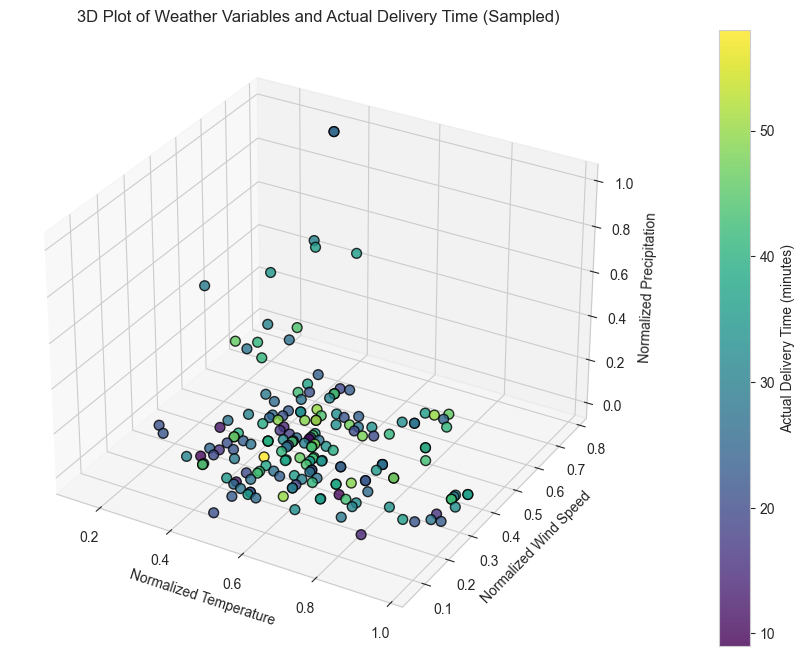

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


sql_query = """
WITH WeatherStats AS (
    SELECT
        MIN(CLOUD_COVERAGE) AS MinCloud,
        MAX(CLOUD_COVERAGE) AS MaxCloud,
        MIN(TEMPERATURE) AS MinTemp,
        MAX(TEMPERATURE) AS MaxTemp,
        MIN(WIND_SPEED) AS MinWind,
        MAX(WIND_SPEED) AS MaxWind,
        MIN(PRECIPITATION) AS MinPrecip,
        MAX(PRECIPITATION) AS MaxPrecip
    FROM deliveries
),
NormalizedWeather AS (
    SELECT
        (TEMPERATURE - MinTemp) / (MaxTemp - MinTemp) AS NormTemperature,
        (WIND_SPEED - MinWind) / (MaxWind - MinWind) AS NormWindSpeed,
        (PRECIPITATION - MinPrecip) / (MaxPrecip - MinPrecip) AS NormPrecipitation,
        ACTUAL_DELIVERY_MINUTES AS ActualDeliveryTime,
        CASE
            WHEN PRECIPITATION = 0 THEN 'No Rain'
            WHEN PRECIPITATION < 0.5 THEN 'Light Rain'
            ELSE 'Heavy Rain'
        END AS PrecipitationCategory
    FROM deliveries, WeatherStats
)
SELECT
    NormTemperature,
    NormWindSpeed,
    NormPrecipitation,
    PrecipitationCategory,
    ActualDeliveryTime
FROM NormalizedWeather;
"""

weather_df = pd.read_sql(sql_query, conn)

sampled_weather_df = weather_df.sample(frac=0.01, random_state=42)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
x = sampled_weather_df['NormTemperature']
y = sampled_weather_df['NormWindSpeed']
z = sampled_weather_df['NormPrecipitation']
avg_delivery_time = sampled_weather_df['ActualDeliveryTime']
cmap = plt.get_cmap('viridis')
sc = ax.scatter(x, y, z, c=avg_delivery_time, cmap=cmap, s=50, alpha=0.8, edgecolors='k')
ax.set_xlabel('Normalized Temperature')
ax.set_ylabel('Normalized Wind Speed')
ax.set_zlabel('Normalized Precipitation')
plt.title('3D Plot of Weather Variables and Actual Delivery Time (Sampled)')
cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label('Actual Delivery Time (minutes)')
plt.savefig(os.path.join(output_plot_dir, "3d_weather_delivery.png"))
plt.show()


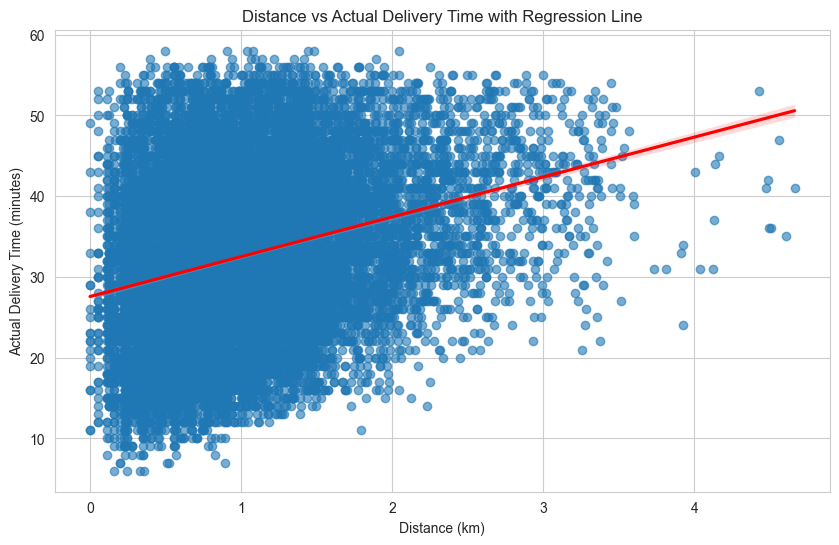

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.feature_engineering import compute_geographical_distance

sql_query = """
WITH WeatherStats AS (
    SELECT
        MIN(CLOUD_COVERAGE) AS MinCloud,
        MAX(CLOUD_COVERAGE) AS MaxCloud,
        MIN(TEMPERATURE) AS MinTemp,
        MAX(TEMPERATURE) AS MaxTemp,
        MIN(WIND_SPEED) AS MinWind,
        MAX(WIND_SPEED) AS MaxWind,
        MIN(PRECIPITATION) AS MinPrecip,
        MAX(PRECIPITATION) AS MaxPrecip
    FROM deliveries
)
SELECT
    USER_LAT AS UserLat,
    USER_LONG AS UserLon,
    VENUE_LAT AS VenueLat,
    VENUE_LONG AS VenueLon,
    ACTUAL_DELIVERY_MINUTES AS ActualDeliveryTime
FROM deliveries;
"""

deliveries_df = pd.read_sql(sql_query, conn)
deliveries_df['DistanceKm'] = deliveries_df.apply(
    lambda row: compute_geographical_distance(
        row['UserLat'], row['UserLon'], row['VenueLat'], row['VenueLon']
    ), axis=1
)

plt.figure(figsize=(10, 6))
sns.regplot(x='DistanceKm', y='ActualDeliveryTime', data=deliveries_df, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title('Distance vs Actual Delivery Time with Regression Line')
plt.xlabel('Distance (km)')
plt.ylabel('Actual Delivery Time (minutes)')
plt.savefig(os.path.join(output_plot_dir, "distance_delivery_regression.png"))
plt.show()

### 3.3. Check Correlations Between Numeric Features


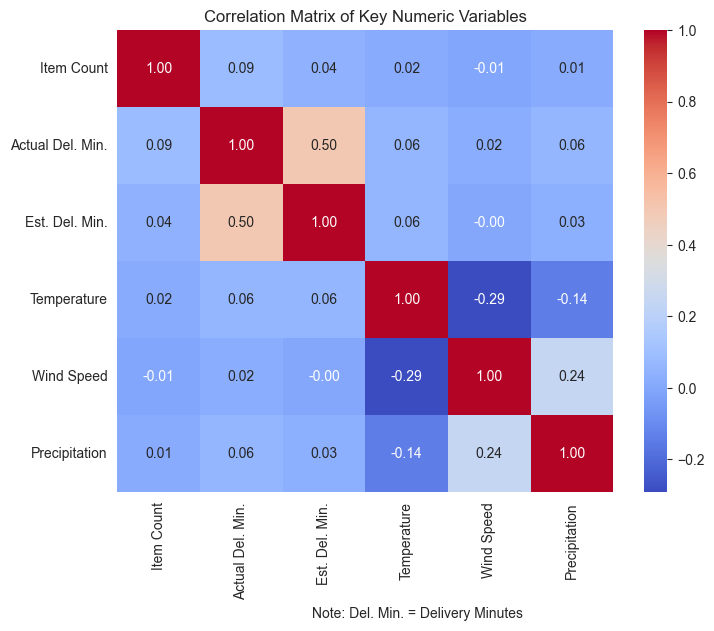

In [13]:
import os
import seaborn as sns
import matplotlib.pyplot as plt


col_mapping = {
    "ITEM_COUNT": "Item Count",
    "ACTUAL_DELIVERY_MINUTES": "Actual Del. Min.",
    "ESTIMATED_DELIVERY_MINUTES": "Est. Del. Min.",
    "TEMPERATURE": "Temperature",
    "WIND_SPEED": "Wind Speed",
    "PRECIPITATION": "Precipitation"
}

df_renamed = df.rename(columns=col_mapping)
num_cols_renamed = list(col_mapping.values())
corr_df = df_renamed[num_cols_renamed].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Key Numeric Variables")
plt.figtext(0.5, -0.1, "Note: Del. Min. = Delivery Minutes", ha="center", fontsize=10)
plt.savefig(os.path.join(output_plot_dir, "correlation_matrix.png"), dpi=300, bbox_inches='tight')
plt.show()